In [ ]:
''' Identify important content-level video features for each pipeline.
Challenge: 1. many features are highly correlated. how to reduce redundancy.
           2. identify "all" important features.
           
High-level description of our feature selection (two steps):
            1. Remove highly correlated features.
            2. Identify important features using different kinds of feature selection methods.
'''

In [1]:
import os
from collections import defaultdict
import glob
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge, 
								  Lasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from minepy import MINE
import operator
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
from pipeline_performance_loader import Parser, initialization, read_feature
from sklearn.base import BaseEstimator, TransformerMixin
from VIF import ReduceVIF
import seaborn as sns

In [2]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))


def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def topK_index(data, K):
    indices = data.argsort()[-1*K:][::-1]
    return indices, data[indices]

In [3]:
def feature_filtering(df, filter_method='pearson'):
	# remove correlated features
	if filter_method == 'VIF':
		# filter 
		transformer = ReduceVIF(thresh=5)
		df_filtered = transformer.fit_transform(df)
		return df_filtered
	elif filter_method == 'pearson':
		# filter feateures with pearson correlation higher than a thresh
		corr_matrix = df.corr()
		correlated_features = set()
		thresh = 0.8
		for i in range(len(corr_matrix.columns)):
			for j in range(i):
				if abs(corr_matrix.iloc[i, j]) > thresh:
					colname = corr_matrix.columns[i]
					correlated_features.add(colname)
		df_filtered = df.drop(correlated_features, axis=1)
		return df_filtered

	
	else:
		print('Filter method {} does not exist.'.format(filter_method))
		return df

In [4]:
# Load pipeline performance
all_feature_names, moving, video_to_delete, selected_video, glimpse_video_to_delete = initialization()
path = '/Users/zhujunxiao/Desktop/benchmarking/vldb/data/'
# feature_file = path + 'features_all_type_width_height_filter.csv'
feature_file = path + 'allvideo_features_long.csv'

features = read_feature(feature_file)

videostorm_path = path + 'videostorm/overfitting_results/'
videostorm_parser = Parser('videostorm', 
                          videostorm_path)
videostorm_perf = videostorm_parser.load_perf()


glimpse_path = path + 'glimpse/glimpse_frame_select_results/'
glimpse_parser = Parser('glimpse', 
                         glimpse_path,
                         glimpse_video_to_delete,
                         moving)
glimpse_perf, moving_or_not = glimpse_parser.load_perf()


path = '/Users/zhujunxiao/Desktop/benchmarking/vldb/data/vigil/vigil_mobilenet_results_10_11/'
pipeline = 'vigil'
vigil_parser = Parser(pipeline, path, video_to_delete)
vigil_perf = vigil_parser.load_perf()




In [5]:
target_perf = vigil_perf
NUM_OF_FEATURES=2


In [10]:

X = []
y = []

for key in sorted(target_perf.keys()):
    if key not in features:
        continue

    # data cleaning
    if features[key][all_feature_names.index('object_cn_avg')] <= 0:
        continue
    if features[key][all_feature_names.index('velocity_avg')] < 1:
        continue
    if features[key][all_feature_names.index('object_size_avg')] <= 0:
        continue

    if target_perf[key][1] < 0.8:
        continue
    X.append(features[key])
    y.append(target_perf[key][0])

# preprocessing: standardization, and train test split
print('Preprocessing starts (normalization, train_test_split)......')
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)  
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                    test_size=0.2, random_state=0) 

print('Preprocessing done!')

crossroad4_20
crossroad4_29
drift_33
driving1_17
driving1_29
driving1_32
driving1_6
driving2_0
driving2_11
driving2_12
driving2_17
driving2_21
driving2_22
driving2_23
driving2_32
driving2_34
driving2_36
driving2_37
driving2_38
motorway_0
motorway_1
motorway_10
motorway_11
motorway_12
motorway_13
motorway_14
motorway_15
motorway_16
motorway_17
motorway_18
motorway_3
motorway_4
motorway_5
motorway_6
motorway_7
motorway_8
motorway_9
park_0
park_1
park_11
park_14
park_15
park_16
park_17
park_18
park_19
park_20
park_21
park_22
park_23
park_24
park_25
park_26
park_27
park_28
park_29
park_30
park_33
park_34
park_36
park_37
park_4
park_5
park_7
russia1_1
Preprocessing starts (normalization, train_test_split)......
Preprocessing done!


After pearson correlation filtering, remaining features: Index(['object_cn_median', 'object_cn_skewness', 'object_size_median',
       'object_size_avg', 'object_size_mode', 'object_size_var',
       'object_size_skewness', 'arrival_rate_var', 'arrival_rate_skewness',
       'velocity_median', 'velocity_mode', 'velocity_var', 'velocity_skewness',
       'total_area_var', 'number_of_object_classes'],
      dtype='object')
ReduceVIF fit
ReduceVIF transform


/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping object_cn_median with vif=inf
Dropping object_cn_avg with vif=inf
Dropping object_cn_mode with vif=inf
Dropping object_cn_var with vif=inf
Dropping object_cn_std with vif=inf
Dropping object_cn_skewness with vif=inf
Dropping object_cn_kurtosis with vif=inf
Dropping object_cn_second_moment with vif=inf
Dropping object_cn_percentile5 with vif=inf
Dropping object_cn_percentile25 with vif=inf
Dropping object_cn_percentile75 with vif=inf
Dropping object_cn_percentile95 with vif=inf
Dropping object_cn_iqr with vif=inf
Dropping object_size_var with vif=inf
Dropping object_size_percentile25 with vif=inf
Dropping arrival_rate_var with vif=inf
Dropping arrival_rate_percentile25 with vif=inf
Dropping velocity_var with vif=inf
Dropping velocity_percentile25 with vif=inf
Dropping total_area_var with vif=inf
Dropping total_area_percentile25 with vif=inf
Dropping total_area_avg with vif=170556179.68708134
Dropping arrival_rate_avg with vif=86565.96821840032
Dropping velocity_avg with vif=373

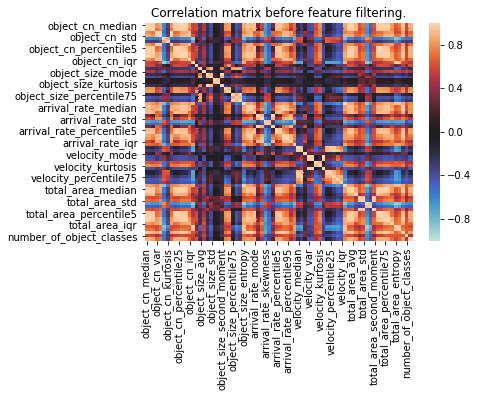

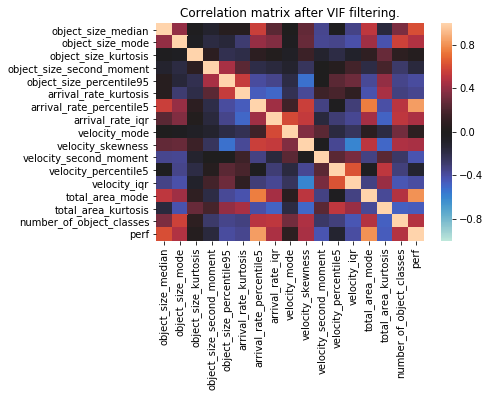

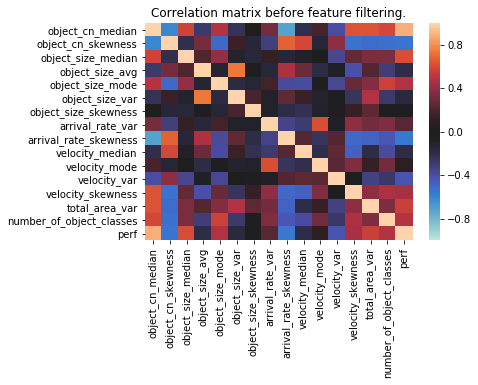

In [11]:
# remove correlated features, using two methods
df = pd.DataFrame(X_train, columns=all_feature_names)
df_filtered_pearson = feature_filtering(df)
print('After pearson correlation filtering, remaining features:', df_filtered_pearson.columns)
df_filtered_vif = feature_filtering(df, filter_method='VIF')
print('After VIF filtering, remaining features:', df_filtered_vif.columns)

# visualize correlation matrix before and after filtering
df['perf'] = y_train
df_filtered_pearson['perf'] = y_train
df_filtered_vif['perf'] = y_train

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
cor = df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()
cor = df_filtered_vif.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix after VIF filtering.')
plt.show()
cor = df_filtered_pearson.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()	


In [ ]:
# Implement multiple types of feature selection methods. And compare their selected results.

def select_good_features(X, Y, names, n_features_to_select=5):
    ranks = {}
    lr = LinearRegression(normalize=True)
    lr.fit(X, Y)
    ranks["Linear"] = rank_to_dict(np.abs(lr.coef_), names)

    ridge = Ridge(alpha=7)
    ridge.fit(X, Y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)


    lasso = Lasso(alpha=.05)
    lasso.fit(X, Y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)


    #stop the search when 5 features are left (they will get equal scores)
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X,Y)
    ranks["RFE"] = rank_to_dict(rfe.ranking_, names, order=-1)

    rf = RandomForestRegressor()
    rf.fit(X,Y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


    f, pval  = f_regression(X, Y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)

    mine = MINE()
    mic_scores = []
    for i in range(X.shape[1]):
        mine.compute_score(X[:,i], Y)
        m = mine.mic()
        mic_scores.append(m)

    ranks["MIC"] = rank_to_dict(mic_scores, names) 
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

  

    # rank = [np.abs(x) for x in lr.feature_importances_]
    # indicies = topK_index(np.asarray(rank), 3)

    # for i in indicies[0]:
    # 	print(all_feature_names[i])

    return methods, ranks





In [ ]:
features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


In [ ]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

In [ ]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)


In [ ]:
features = df_filtered_pearson.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_pearson['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


In [ ]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

In [ ]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

In [ ]:
features = df_filtered_vif.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_vif['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


In [ ]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

In [ ]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

In [ ]:
from scipy.stats import pearsonr

features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
correlation_thresh = 0.8
correlated_features = []
for name in names:
    (r, p) = pearsonr(df[name], df['perf'])
    if np.abs(r) > correlation_thresh:
        correlated_features.append((name,r))
correlated_features.sort(key=lambda x: x[1], reverse=True)
print(correlated_features)
selected_features = [correlated_features[0][0]]
for feature in correlated_features[1:]:
    (r, p) = pearsonr(df[feature[0]], df[correlated_features[0][0]])
    if np.abs(r) <= 0.8:
        selected_features.append(feature[0])
print('Final selected feature:', selected_features)